## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
import keras
from keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [3]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [6]:
results = {}

import itertools
for preact, bz in itertools.product(PRE_ACTIVATE, BATCH_SIZE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Pre Activation: %s, Batch_size: %i" % (preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "Pre Activation: %s, Batch_size: %s" % (preact, str(bz))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Pre Activation: True, Batch_size: 32
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)        

1563/1563 [==============================] - 22s 14ms/step - loss: 0.2846 - accuracy: 0.9009 - val_loss: 2.5838 - val_accuracy: 0.5052
Epoch 43/50
1563/1563 [==============================] - 22s 14ms/step - loss: 0.2788 - accuracy: 0.8997 - val_loss: 2.4157 - val_accuracy: 0.5167
Epoch 44/50
1563/1563 [==============================] - 22s 14ms/step - loss: 0.2682 - accuracy: 0.9042 - val_loss: 2.5955 - val_accuracy: 0.5020
Epoch 45/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.2671 - accuracy: 0.9042 - val_loss: 2.5519 - val_accuracy: 0.5057
Epoch 46/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.2683 - accuracy: 0.9058 - val_loss: 2.8535 - val_accuracy: 0.4710
Epoch 47/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.2531 - accuracy: 0.9100 - val_loss: 2.4972 - val_accuracy: 0.4981
Epoch 48/50
1563/1563 [==============================] - 24s 15ms/step - loss: 0.2517 - accuracy: 0.9098 - val_loss: 2.6786 - val_

391/391 [==============================] - 8s 20ms/step - loss: 0.1342 - accuracy: 0.9532 - val_loss: 3.6694 - val_accuracy: 0.4498
Epoch 35/50
391/391 [==============================] - 8s 21ms/step - loss: 0.1331 - accuracy: 0.9543 - val_loss: 2.9423 - val_accuracy: 0.5033
Epoch 36/50
391/391 [==============================] - 8s 22ms/step - loss: 0.1247 - accuracy: 0.9566 - val_loss: 3.0647 - val_accuracy: 0.4877
Epoch 37/50
391/391 [==============================] - 8s 21ms/step - loss: 0.1264 - accuracy: 0.9547 - val_loss: 3.1929 - val_accuracy: 0.4780
Epoch 38/50
391/391 [==============================] - 9s 22ms/step - loss: 0.1233 - accuracy: 0.9564 - val_loss: 3.1913 - val_accuracy: 0.4625
Epoch 39/50
391/391 [==============================] - 9s 22ms/step - loss: 0.1229 - accuracy: 0.9568 - val_loss: 3.7639 - val_accuracy: 0.4772
Epoch 40/50
391/391 [==============================] - 8s 21ms/step - loss: 0.1062 - accuracy: 0.9623 - val_loss: 3.5757 - val_accuracy: 0.4662
Epoc

196/196 [==============================] - 5s 26ms/step - loss: 0.1384 - accuracy: 0.9534 - val_loss: 2.9227 - val_accuracy: 0.4448
Epoch 27/50
196/196 [==============================] - 5s 26ms/step - loss: 0.1520 - accuracy: 0.9487 - val_loss: 3.0493 - val_accuracy: 0.4923
Epoch 28/50
196/196 [==============================] - 5s 26ms/step - loss: 0.1422 - accuracy: 0.9521 - val_loss: 2.9918 - val_accuracy: 0.4729
Epoch 29/50
196/196 [==============================] - 5s 26ms/step - loss: 0.1205 - accuracy: 0.9594 - val_loss: 3.0064 - val_accuracy: 0.4919
Epoch 30/50
196/196 [==============================] - 5s 27ms/step - loss: 0.1148 - accuracy: 0.9612 - val_loss: 3.4679 - val_accuracy: 0.4645
Epoch 31/50
196/196 [==============================] - 5s 25ms/step - loss: 0.1221 - accuracy: 0.9576 - val_loss: 3.4888 - val_accuracy: 0.4566
Epoch 32/50
196/196 [==============================] - 5s 27ms/step - loss: 0.1124 - accuracy: 0.9627 - val_loss: 3.5189 - val_accuracy: 0.4477
Epoc

1563/1563 [==============================] - 23s 15ms/step - loss: 1.1237 - accuracy: 0.6002 - val_loss: 1.3804 - val_accuracy: 0.5203
Epoch 19/50
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1146 - accuracy: 0.6042 - val_loss: 1.3833 - val_accuracy: 0.5208
Epoch 20/50
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1038 - accuracy: 0.6079 - val_loss: 1.4513 - val_accuracy: 0.5045
Epoch 21/50
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0873 - accuracy: 0.6135 - val_loss: 1.3807 - val_accuracy: 0.5152
Epoch 22/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0774 - accuracy: 0.6171 - val_loss: 1.3873 - val_accuracy: 0.5171
Epoch 23/50
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0637 - accuracy: 0.6212 - val_loss: 1.4090 - val_accuracy: 0.5144
Epoch 24/50
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0571 - accuracy: 0.6231 - val_loss: 1.4808 - val_

391/391 [==============================] - 8s 21ms/step - loss: 1.1106 - accuracy: 0.6053 - val_loss: 1.4380 - val_accuracy: 0.4971
Epoch 10/50
391/391 [==============================] - 9s 22ms/step - loss: 1.0732 - accuracy: 0.6186 - val_loss: 1.5441 - val_accuracy: 0.4748
Epoch 11/50
391/391 [==============================] - 8s 20ms/step - loss: 1.0414 - accuracy: 0.6287 - val_loss: 1.5814 - val_accuracy: 0.4689
Epoch 12/50
391/391 [==============================] - 8s 21ms/step - loss: 1.0144 - accuracy: 0.6390 - val_loss: 1.6624 - val_accuracy: 0.4437
Epoch 13/50
391/391 [==============================] - 9s 22ms/step - loss: 0.9834 - accuracy: 0.6495 - val_loss: 1.5420 - val_accuracy: 0.4804
Epoch 14/50
391/391 [==============================] - 7s 17ms/step - loss: 0.9511 - accuracy: 0.6618 - val_loss: 1.4599 - val_accuracy: 0.5007
Epoch 15/50
391/391 [==============================] - 7s 19ms/step - loss: 0.9242 - accuracy: 0.6725 - val_loss: 1.4768 - val_accuracy: 0.4993
Epoc

196/196 [==============================] - 7s 28ms/step - loss: 1.6930 - accuracy: 0.4030 - val_loss: 1.7087 - val_accuracy: 0.3826
Epoch 2/50
196/196 [==============================] - 5s 27ms/step - loss: 1.4819 - accuracy: 0.4729 - val_loss: 1.8390 - val_accuracy: 0.3655
Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 1.3881 - accuracy: 0.5095 - val_loss: 1.7223 - val_accuracy: 0.3872
Epoch 4/50
196/196 [==============================] - 5s 27ms/step - loss: 1.3161 - accuracy: 0.5334 - val_loss: 1.7826 - val_accuracy: 0.3884
Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 1.2634 - accuracy: 0.5522 - val_loss: 1.7353 - val_accuracy: 0.4050
Epoch 6/50
196/196 [==============================] - 5s 25ms/step - loss: 1.2108 - accuracy: 0.5696 - val_loss: 1.7714 - val_accuracy: 0.4045
Epoch 7/50
196/196 [==============================] - 5s 25ms/step - loss: 1.1694 - accuracy: 0.5841 - val_loss: 1.6188 - val_accuracy: 0.4324
Epoch 8/50

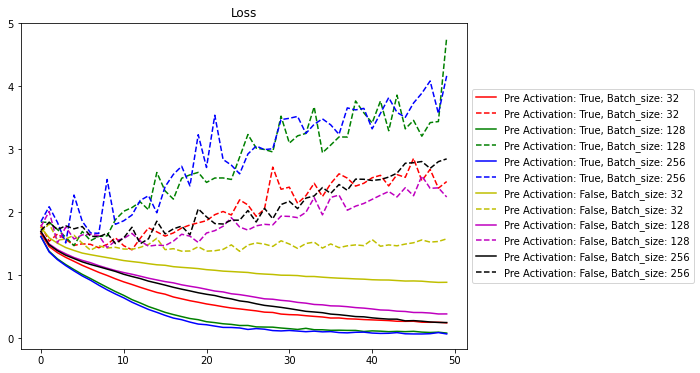

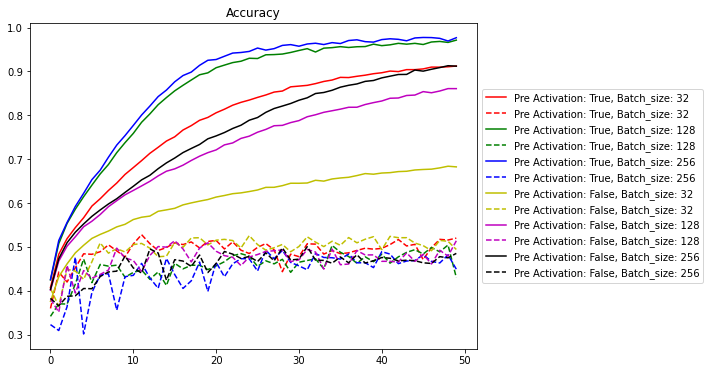

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()